# Honour Code
I **Bafana, Nkomo**, confirm - by submitting my - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code (https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract

# Importing Some Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import f1_score

#Loading Our Data Sets

In [0]:
sample_sub = pd.read_csv('../content/sample_submission.csv')
train = pd.read_csv('../content/training.csv')
test = pd.read_csv('../content/test.csv')
#var_def = pd.read_csv('../content/Xente_Variable_definitions.csv')

# Console Text Styles Simplified For Readibilty

In [0]:
class bcolors:
    HEADER = '\033[95m'
    #OKBLUE = '\033[94m'
    #OKGREEN = '\033[92m'
    #WARNING = '\033[93m'
    #FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Quick look at Our Dependent Variable in our Training Set

NoFraud: 95469
Fraud: 193
Proportion: 494.66 : 1


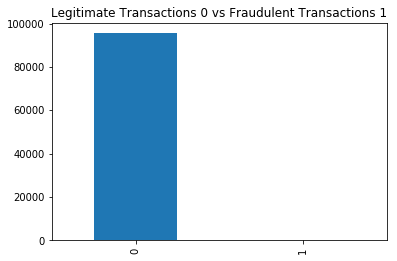

In [6]:
target_count = train['FraudResult'].value_counts()
print('NoFraud:', target_count[0])
print('Fraud:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Legitimate Transactions 0 vs Fraudulent Transactions 1');

In [0]:
# Class count
count_legit, count_fraud = train['FraudResult'].value_counts()

# Divide by class
df_legit = train[train['FraudResult'] == 0]
df_fraud = train[train['FraudResult'] == 1]

It looks like our data is imbalanced and something must be done here to combat a bias within our models. SO we resample to try and restablish some unbiasedness. To find out which resampling technique will work best here, we will go by trial and error to see which gives out the best result for each classification algorithm.

# Resampling

## Random Under Sampling
TO illustrate the method here, all thats done is randomly taking less of the over represented outcome to match the number found in the under represented data.

Random under-sampling:
1    193
0    193
Name: FraudResult, dtype: int64


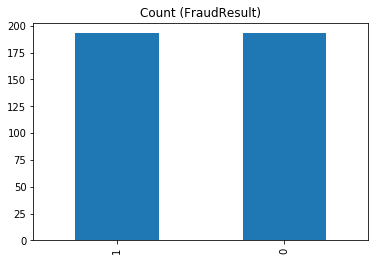

In [8]:
df_legit_under = df_legit.sample(count_fraud)
df_test_under = pd.concat([df_legit_under, df_fraud], axis=0)

print('Random under-sampling:')
print(df_test_under['FraudResult'].value_counts())

df_test_under['FraudResult'].value_counts().plot(kind='bar', title='Count (FraudResult)');

##  Random over-sampling
To illustrate the point, all that's done here is to randomly duplicate the under represented data enough enough times to match the over represented data.


Random over-sampling:
1    95469
0    95469
Name: FraudResult, dtype: int64


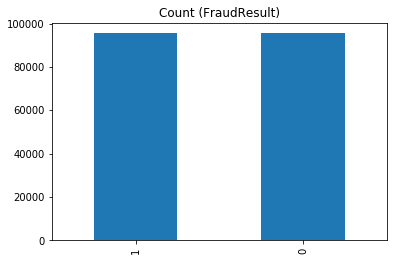

In [9]:
df_fraud_over = df_fraud.sample(count_legit, replace=True)
df_test_over = pd.concat([df_legit, df_fraud_over], axis=0)

print('Random over-sampling:')
print(df_test_over['FraudResult'].value_counts())

df_test_over['FraudResult'].value_counts().plot(kind='bar', title='Count (FraudResult)');

We will use imblearn library to resample our data in different ways, but first lets have a look at our data set further

# Missing Data
We want to handle any missing found in our data especially our test data set since mainting TransactionIds is important there and handling missing data could go beyond just dropping missing columns or rows.

In [0]:
#missing data
def missing_check(df_check):
  '''This function check a dataframe for missing values and returns the percentage of the missing values in each column as a dataframe'''
  all_data_na = (df_check.isnull().sum() / len(df_check)) * 100
  all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
  missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
  return missing_data

We check the training data for missing values. If anuy mmissing values are found here, we will just delete the rows iin which they occur. There shouldn't be too many columns of concern.

In [11]:
missing_check(train)

,Missing Ratio


We got lucky and it seems like there are no missing vallues in the training set.

In [0]:
#we do not need this at this stage.
#train.dropna(inplace = True)

We check the test set for missing data. If there are missing values here, we will have to impute the data should there be too many meaningful columns which have missing values. But we will see what happens first before we decide what to do.

In [13]:
missing_check(test)

,Missing Ratio


Thank God! No misisng values in the test set. Ask no questions, hear no lies. We will move onto preparing our data.

# Preprocessing Officially  Begins

We save our training data's FraudResult to a series for later use as well as the number of items in our training set and test set, and we finally save our training set and test set's TransactionId's.

In [0]:
y_train_final = train['FraudResult']
ntrain = train.shape[0]
ntest = test.shape[0]
train_ID = train['TransactionId']
test_ID = test['TransactionId']

We combine our train and test sets. From here we must be careful not to order or shuffle our data to preserve the TransactionIds

In [0]:
# combine 2 sets train then test
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)

We have to handle the TransactionStartTime column. We atomise this column all the way down to the minute the transaction was started. I feel that this may be important information. We then save these as integers and then we can move onto our next step

In [0]:
all_data['TransactionStartTime'] = pd.to_datetime(all_data['TransactionStartTime'])
all_data['TransactionMinute'] = all_data['TransactionStartTime'].dt.minute
all_data['TransactionHour'] = all_data['TransactionStartTime'].dt.hour
all_data['TransactionDay'] = all_data['TransactionStartTime'].dt.day
all_data['TransactionMonth'] = all_data['TransactionStartTime'].dt.month
all_data['TransactionYear'] = all_data['TransactionStartTime'].dt.year

In [17]:
#check to see what columns we still have
all_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'TransactionMinute', 'TransactionHour', 'TransactionDay',
       'TransactionMonth', 'TransactionYear'],
      dtype='object')

## Let Dimensionality Reduction Begin

We want to be smart about how we select our features here. Time is limited and we would like to avoid making too many dummy variables. earlier tests gave out a combinede dataset of 3GB in size so since we are in a competition and we must watch the clock, we will avoid making dummies in the columns with thousands of unique entries and unique entries equal to the ttal number of transactions.

In [20]:
print('Number of Transactions:' + str(len(all_data)) + '\n')

for column in all_data.columns:
  print(bcolors.BOLD + column + ':' + bcolors.ENDC )
  print( "Number of unique values:" + str(len(all_data[column].unique())) + '\n')


Number of Transactions:140681

TransactionId:
Number of unique values:140681

BatchId:
Number of unique values:139493

AccountId:
Number of unique values:4841

SubscriptionId:
Number of unique values:4836

CustomerId:
Number of unique values:7479

CurrencyCode:
Number of unique values:1

CountryCode:
Number of unique values:1

ProviderId:
Number of unique values:6

ProductId:
Number of unique values:27

ProductCategory:
Number of unique values:10

ChannelId:
Number of unique values:5

Amount:
Number of unique values:2099

Value:
Number of unique values:1880

TransactionStartTime:
Number of unique values:138574

PricingStrategy:
Number of unique values:4

FraudResult:
Number of unique values:3

TransactionMinute:
Number of unique values:60

TransactionHour:
Number of unique values:24

TransactionDay:
Number of unique values:31

TransactionMonth:
Number of unique values:5

TransactionYear:
Number of unique values:2



In [0]:
# These are the columns we chose to remove
all_data.drop( columns = ['TransactionYear','TransactionId','BatchId', 'AccountId','CustomerId', 'SubscriptionId','TransactionStartTime', 'FraudResult', 'CountryCode', 'CurrencyCode', 'Value'], inplace = True )
#all_data.drop(columns = ['TransactionId', 'ProductId','ProviderId', 'SubscriptionId','TransactionStartTime', 'FraudResult', 'CountryCode', 'CurrencyCode', 'Value'])

## Data types

We want to maintain the right datatypes for our ML algorithms and calculations. SO we will monitor our datatypes and change the ones that do not match their description logically.For example: we can't have Amount as an int when Amount should be float etc.

In [22]:
all_data.dtypes

ProviderId            object
ProductId             object
ProductCategory       object
ChannelId             object
Amount               float64
PricingStrategy        int64
TransactionMinute      int64
TransactionHour        int64
TransactionDay         int64
TransactionMonth       int64
dtype: object

In [0]:
#We turn PricingStrategy into a string since it is a categorical variable, specifically a nominal categorical varaible
all_data['PricingStrategy'] = all_data['PricingStrategy'].astype('str') 

In [0]:
#At a later date, if there are more years to consider and not just 1 or 2, we will make year a categorical variable.
#But there are a lot of years to go through in the set, we will keep year as an int, but for now year was dropped because 
#there were only 2 of them to consider and this would not tell us much about our data 
#all_data['TransactionYear'] = all_data['TransactionYear'].astype('str')

In [25]:
#I still could not believe that there were no missing values in the training and test set so I checked again
#Checking all_data will obviously yield missing values since the test set has no values for the FraudResult column
missing_check(train)

,Missing Ratio


In [26]:
missing_check(test)

,Missing Ratio


## To Standardise or Normalise? That is the question.
We want to see which performs best, if there's time, standardising or normalising. We will use Yeo-Johnson's Tranformation through PowerTransformer and MinMaScaler since they are not sensitive to outliers.

In [0]:
from sklearn.preprocessing import PowerTransformer

In [0]:
power_transformer =  PowerTransformer(method='yeo-johnson')
#all_data = pd.concat((all_data[['ProductCategory', 'ChannelId', 'PricingStrategy', 'TransactionYear']], 
#                      power_transformer.fit_transform(all_data[['TransactionMinute','TransactionHour',
#                                                                 'TransactionDay','TransactionMonth',
#                                                                 'TransactionYear','Amount']])), sort=False).reset_index(drop=True)
transformed_cont =  power_transformer.fit_transform(all_data[['TransactionMinute','TransactionHour',
                                                              'TransactionDay','TransactionMonth','Amount']])

df = pd.DataFrame({'ProductCategory':all_data['ProductCategory'], 'ChannelId':all_data['ChannelId'], 
                   'PricingStrategy':all_data['PricingStrategy'], 'ProductId':all_data['ProductId'],
                   'ProviderId':all_data['ProviderId'],
                   'TransactionMinute': transformed_cont[:,0],'TransactionHour': transformed_cont[:,1], 
                   'TransactionDay': transformed_cont[:,2],'TransactionMonth': transformed_cont[:,3],
                   'Amount': transformed_cont[:,4]})

In [0]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

minmax_cont =  minmax_scaler.fit_transform(all_data[['TransactionMinute','TransactionHour',
                                                              'TransactionDay','TransactionMonth','Amount']])

df_minmax = pd.DataFrame({'ProductCategory':all_data['ProductCategory'], 'ChannelId':all_data['ChannelId'], 
                   'PricingStrategy':all_data['PricingStrategy'], 'ProductId':all_data['ProductId'],
                   'ProviderId':all_data['ProviderId'],
                   'TransactionMinute': transformed_cont[:,0],'TransactionHour': transformed_cont[:,1], 
                   'TransactionDay': transformed_cont[:,2],'TransactionMonth': transformed_cont[:,3],
                   'Amount': transformed_cont[:,4]})

In [30]:
#One last look at the datatypes after tranforming
df.dtypes

ProductCategory       object
ChannelId             object
PricingStrategy       object
ProductId             object
ProviderId            object
TransactionMinute    float64
TransactionHour      float64
TransactionDay       float64
TransactionMonth     float64
Amount               float64
dtype: object

In [31]:
#minmax
df_minmax.dtypes

ProductCategory       object
ChannelId             object
PricingStrategy       object
ProductId             object
ProviderId            object
TransactionMinute    float64
TransactionHour      float64
TransactionDay       float64
TransactionMonth     float64
Amount               float64
dtype: object

**Note** MinMax looks like it will be more efficient than PoowerTransformer since the columns are stored as uint8 with values between [0,1] unlike PowerTransformer with float64 and values beyond [-1,1] 

# Let the headaches Begin:
We get our dummy variable. In previous iterations of the notebook, choosing the 'wrong' features would crash our kernel through a memory error. After reading through the documentation and seeing how get_dummies 'gets dummies', we worked around the kernel crashing through using a for loop but this still took forever to run, so we considered converting to a sparse matrix or droping the features causing the slowness. In the end we dropped the features cauing the slowness. It is in line parsimoniousness, but one is unable to shake off the suspicion that there could be valuable information in the dropped columns. Luckily, time is not on our side and we will choose the most time friendly method: dropping the problem columns.  

In [0]:
#Dummies
#all_data = pd.get_dummies(all_data, drop_first=True) #crashes RAM
all_data_cols = df.columns
all_cat_cols = df.select_dtypes(exclude=np.number).columns
all_data_plus = df
#df_final = pd.get_dummies(df)

In [0]:
for column in all_cat_cols:
  df = pd.get_dummies(all_data[[column]], drop_first=True)
  all_data_plus =  pd.concat((all_data_plus, df), axis=1,sort=False, ignore_index=False)
  all_data_plus.drop(columns=[column], inplace = True)
  all_data_plus.columns

In [0]:
#Dummies
#all_data = pd.get_dummies(all_data, drop_first=True) #crashes RAM
minmax_cols = df_minmax.columns
minmax_cat_cols = df_minmax.select_dtypes(exclude=np.number).columns
minmax_data_plus = df_minmax
#df_final = pd.get_dummies(df)

In [0]:
for column in minmax_cat_cols:
  df_minmax = pd.get_dummies(all_data[[column]], drop_first=True)
  minmax_data_plus =  pd.concat((minmax_data_plus, df_minmax), axis=1,sort=False, ignore_index=False)
  minmax_data_plus.drop(columns=[column], inplace = True)
  minmax_data_plus.columns

In [36]:
#what are our new columns?
all_data_plus.columns

Index(['TransactionMinute', 'TransactionHour', 'TransactionDay',
       'TransactionMonth', 'Amount', 'ProductCategory_data_bundles',
       'ProductCategory_financial_services', 'ProductCategory_movies',
       'ProductCategory_other', 'ProductCategory_retail',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_4', 'ChannelId_ChannelId_5', 'PricingStrategy_1',
       'PricingStrategy_2', 'PricingStrategy_4', 'ProductId_ProductId_10',
       'ProductId_ProductId_11', 'ProductId_ProductId_12',
       'ProductId_ProductId_13', 'ProductId_ProductId_14',
       'ProductId_ProductId_15', 'ProductId_ProductId_16',
       'ProductId_ProductId_17', 'ProductId_ProductId_18',
       'ProductId_ProductId_19', 'ProductId_ProductId_2',
       'ProductId_ProductId_20', 'ProductId_ProductId_21',
       'ProductId_ProductId_22', 'ProductId_Product

In [37]:
#The last missing data check, its safe to do this here since there is no column for FraudResult
missing_check(all_data_plus)

,Missing Ratio


# Filing in the Divorce Papers: Train and Test Must Be split
Here we split the data back to train and test just like they were in the csv files however they have changed somewhat during prprocessing and have columns and entries prepped and ready for us to use for further steps.

In [0]:
Xtrain = all_data_plus[:ntrain]
Xtest = all_data_plus[ntrain:]

In [39]:
Xtrain.head()

,TransactionMinute,TransactionHour,TransactionDay,TransactionMonth,Amount,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_4,ChannelId_ChannelId_5,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,ProductId_ProductId_10,ProductId_ProductId_11,ProductId_ProductId_12,ProductId_ProductId_13,ProductId_ProductId_14,ProductId_ProductId_15,ProductId_ProductId_16,ProductId_ProductId_17,ProductId_ProductId_18,ProductId_ProductId_19,ProductId_ProductId_2,ProductId_ProductId_20,ProductId_ProductId_21,ProductId_ProductId_22,ProductId_ProductId_23,ProductId_ProductId_24,ProductId_ProductId_25,ProductId_ProductId_26,ProductId_ProductId_27,ProductId_ProductId_3,ProductId_ProductId_4,ProductId_ProductId_5,ProductId_ProductId_6,ProductId_ProductId_7,ProductId_ProductId_8,ProductId_ProductId_9,ProviderId_ProviderId_2,ProviderId_ProviderId_3,ProviderId_ProviderId_4,ProviderId_ProviderId_5,ProviderId_ProviderId_6
0,-0.565147,-2.140289,0.071567,1.226264,0.019220,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.502868,-2.140289,0.071567,1.226264,0.006675,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0.852493,-2.140289,0.071567,1.226264,0.013482,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.240559,-1.933063,0.071567,1.226264,0.201230,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.346543,-1.933063,0.071567,1.226264,-0.010988,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


# Train Test Split

In [0]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xtrain, y_train_final, test_size = 0.2, random_state = 1111 )
#try 75/25 - I had already passed my submission limit and could not test these
#try 90/10 - I had already passed my submission limit and could not test these
#try 50/50 - I had already passed my submission limit and could not test these
#try 60/40 - I had already passed my submission limit and could not test these
#try 85/15 - I had already passed my submission limit and could not test these
#luckily I found a satissfactory result with my last entry into the competition whch I am haappy with. I beat laura_the_explorer, for now...

# Resampling
As promised, we dive into resampling for real this time. We prep all the resampling techniques that we know of for the next steps. In this case I suspect that Over Sampling will work best here, but I stand to be corrected.

In [41]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)
X_rus = pd.DataFrame(data=X_rus, columns=X_train.columns)
y_rus= pd.DataFrame(data=y_rus,columns=['FraudResult'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)
X_ros = pd.DataFrame(data=X_ros, columns=X_train.columns)
y_ros= pd.DataFrame(data=y_ros,columns=['FraudResult'])

In [0]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X_train, y_train)
X_tl = pd.DataFrame(data=X_tl, columns=X_train.columns)
y_tl= pd.DataFrame(data=y_tl,columns=['FraudResult'])

In [0]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio='auto')
X_cc, y_cc = cc.fit_sample(X_train, y_train)
X_cc = pd.DataFrame(data=X_cc, columns=X_train.columns)
y_cc= pd.DataFrame(data=y_cc,columns=['FraudResult'])

In [0]:
from imblearn.over_sampling import SMOTE 
smote_algo = SMOTE(random_state=1111)
X_smote, y_smote = smote_algo.fit_sample(X_train, y_train)
X_smote = pd.DataFrame(data=X_smote, columns=X_train.columns)
y_smote = pd.DataFrame(data=y_smote,columns=['FraudResult'])

In [0]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto', random_state=1111)
X_smt, y_smt = smt.fit_sample(Xtrain, y_train_final)
X_smt = pd.DataFrame(data=X_smt, columns=Xtrain.columns)
y_smt = pd.DataFrame(data=y_smt,columns=['FraudResult'])

# Output

In [47]:
#This what we want our csv to look like in the end, so we will abuild a function 
#to stop ourselves from committing the sin of repeated code
sample_sub.head()

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


In [0]:
def output_csv(file_name, preds):
  '''This function outputs a csv in the format required by the Zindi competition
  0 input is replaced with Nan and the index is replaced with TransactionId '''
  
  output=pd.DataFrame({'TransactionId':test_ID.values, 'FraudResult': preds })
  output['FraudResult'] =  output['FraudResult'].replace({0:np.nan})
  output.set_index('TransactionId', inplace = True)
  output.to_csv(file_name)

# Let the Hunt Begin:
Our goal is to find a model which has an f1-score of above 0.70 in the finala Zindi submission. We will try to apply model selection techniques learned in this sprint, but for safety, we will first keep things simple and run everything with default hyperparameter values. We will start with the algorithms which I suspect will give out the best results in the fastest time and escalate the complexity from there, that is, we will concentrate on RandomForestClassifier, LogisticRegressor and GaussianNaiveBayes First, then we will try out others e.g. KNN, AdaBoostClassifier, XGBoostClassifier and others. 
Note that we still have to test out all of the resampling techniques as well.

**Note:** I was under the impression that unlike Kaggle, we wold have an unlimited number of submissions. I was tempted to create a dishonest second profile to enter more submissions in, but I had already achieved a score above 0.7 by the time I ranout of submissions (Thank you Random Forest Classifier and SMOTE Resampling)

# Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

#### No Train Test Split

In [83]:
rfc = forest = RandomForestClassifier(random_state=1111)
rfc.fit(Xtrain, y_train_final)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [129]:
rfc_no_split_train_o_preds = rfc.predict(Xtrain)
rfc_no_split_final_preds = rfc.predict(Xtest)
rfc_no_split_train_preds = rfc.predict(X_train)
rfc_no_split_test_preds = rfc.predict(X_test)


print(bcolors.BOLD + 'RFC No Split f1_scores:' + bcolors.ENDC)
print('X_train: '+ str(f1_score(y_train, rfc_no_split_train_preds)))
print('X_test: ' + str(f1_score(y_test, rfc_no_split_test_preds)))
print('\nTrain Data: ' + str(f1_score(y_train_final, rfc_no_split_train_o_preds)))

RFC No Split f1_scores:
X_train: 0.9908814589665653
X_test: 1.0

Train Data: 0.9921671018276762


In [0]:
output_csv('RFC NoSplit NoSpecial.csv', rfc_no_split_final_preds)

>>**Zindi Score:** (Unable to submit, submission limit passed)

#### With Train Test Split No resampling

In [120]:
forest = RandomForestClassifier(random_state=1111)
forest.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [87]:
# In preparation for GridSearchCV, I'm still trying to learn what the fastest 
# implementation would be and I just might not be able to get to this step before 3pm
# but I'll leave my template in here just in case.

'''n_estimators = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(Xtrain, y_train_final)

#########################################################################
#default hyperparameters
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)
'''

"n_estimators = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300, 500, 800, 1200]\nmax_depth = [5, 8, 15, 25, 30]\nmin_samples_split = [2, 5, 10, 15, 100]\nmin_samples_leaf = [1, 2, 5, 10] \n\nhyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  \n              min_samples_split = min_samples_split, \n             min_samples_leaf = min_samples_leaf)\n\ngridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, \n                      n_jobs = -1)\nbestF = gridF.fit(Xtrain, y_train_final)\n\n#########################################################################\n#default hyperparameters\nRandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n                       max_depth=None, max_features='auto', max_leaf_nodes=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=2,\n                       min_weight_fraction_leaf=0.0, n_estimators=10,\n                       n_jobs=

In [128]:
rfc_train_preds = forest.predict(X_train)
rfc_test_preds = forest.predict(X_test)
rfc_train_o_preds = forest.predict(Xtrain)
rfc_final_preds = forest.predict(Xtest)


print(bcolors.BOLD + 'RFC F1_Scores train_test_split Only' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_train, rfc_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_test_preds)))
print('\nTrain Data:' + str(f1_score(y_train_final, rfc_train_o_preds)))

RFC F1_Scores train_test_split Only
X_train Data: 0.9815950920245399
X_test Data:0.7924528301886792

Train Data:0.9551451187335093


In [0]:
output_csv('RFC Split.csv', rfc_final_preds)

>>  **Zindi Score:** 0.612244897959184




#### RandomUnderSampling Results

In [90]:
rfc_rus = RandomForestClassifier(random_state=1111)
rfc_rus.fit(X_rus, y_rus)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [137]:
rfc_rus_train_preds = rfc_rus.predict(X_rus)
rfc_rus_test_preds = rfc_rus.predict(X_test)
rfc_rus_train_o_preds = rfc_rus.predict(Xtrain)
rfc_rus_final_preds = rfc_rus.predict(Xtest)


print(bcolors.BOLD + 'Random Forest Classifier' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_rus, rfc_rus_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_rus_test_preds)))
print('\nTest Data:' + str(f1_score(y_train_final, rfc_rus_train_o_preds)))

Random Forest Classifier
X_train Data: 1.0
X_test Data:0.13368983957219252

Test Data:0.21766381766381768


In [0]:
output_csv('RFC RUS.csv', rfc_rus_final_preds)

>> **Zindi Score:** 0.141242937853107

### RFC Random Oversampling Results:

In [133]:
rfc_ros = RandomForestClassifier(random_state=1111)
rfc_ros.fit(X_ros, y_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [136]:
rfc_ros_train_preds = rfc_ros.predict(X_ros)
rfc_ros_test_preds = rfc_ros.predict(X_test)
rfc_ros_train_o_preds = rfc_ros.predict(Xtrain)
rfc_ros_final_preds = rfc_ros.predict(Xtest)


print(bcolors.BOLD + 'Random Forest Classifier' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_ros, rfc_ros_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_ros_test_preds)))
print('\nTrain Data:' + str(f1_score(y_train_final, rfc_ros_train_o_preds)))

Random Forest Classifier
X_train Data: 0.9999934523692602
X_test Data:0.7169811320754716

Train Data:0.9585492227979274


In [0]:
output_csv( 'RFC ROS 80-20.csv', rfc_ros_final_preds)

>> **Zindi Score:** 0.679245283018868  

### RFC TomekLinks results:

In [96]:
rfc_tl = RandomForestClassifier( random_state = 1111 )
rfc_tl.fit(X_tl, y_tl) 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [140]:
rfc_tl_train_preds = rfc_tl.predict(X_tl)
rfc_tl_test_preds = rfc_tl.predict(X_test)
rfc_tl_test_o_preds = rfc_tl.predict(Xtrain)
rfc_tl_final_preds = rfc_tl.predict(Xtest)


print(bcolors.BOLD + 'Random Forest Classifier' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_tl, rfc_tl_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_tl_test_preds)))

print('\nTest Data:' + str(f1_score(y_train_final, rfc_ros_train_o_preds)))

Random Forest Classifier
X_train Data: 0.9908814589665653
X_test Data:0.7636363636363638

Test Data:0.9585492227979274


In [0]:
output_csv( 'RFC TomekLinks 80-20.csv', rfc_tl_final_preds)

>> **ZindiScore:** 0.64406779661017

### RFC ClusterCentroids results:

In [99]:
rfc_cc = RandomForestClassifier( random_state = 1111 )
rfc_cc.fit(X_cc, y_cc)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [142]:
rfc_cc_train_preds = rfc_cc.predict( X_cc )
rfc_cc_test_preds = rfc_cc.predict( X_test )

rfc_cc_train_o_preds = rfc_cc.predict( Xtrain )
rfc_cc_final_preds = rfc_cc.predict( Xtest )

print(bcolors.BOLD + 'Random Forest Classifier' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_cc, rfc_cc_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_cc_test_preds)))
print('\nTest Data:' + str(f1_score(y_train_final, rfc_cc_train_o_preds)))


Random Forest Classifier
X_train Data: 1.0
X_test Data:0.0028214640263336645

Test Data:0.004030784332153337


In [0]:
output_csv( 'RFC ClusterCentroids ratio 0-10 80-20_split.csv', rfc_cc_final_preds)

>> **ZindiScore:** 0.00224890927899969

### RFC SMOTE results 

In [102]:
rfc_smote  = RandomForestClassifier( random_state = 1111 )
rfc_smote.fit(X_smote, y_smote)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [144]:
rfc_smote_train_preds = rfc_smote.predict(X_smote)
rfc_smote_test_preds = rfc_smote.predict(X_test)
rfc_smote_train_o_preds = rfc_smote.predict(Xtrain)
rfc_smote_final_preds = rfc_smote.predict(Xtest)

print(bcolors.BOLD + 'Random Forest Classifier' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_smote, rfc_smote_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_smote_test_preds)))
print('\nTrain Data:' + str(f1_score(y_train_final, rfc_smote_train_o_preds)))

Random Forest Classifier
X_train Data: 0.9999541653843886
X_test Data:0.7931034482758621

Train Data:0.9509043927648577


In [0]:
output_csv('RFC SMOTE 80-20_split.csv', rfc_smote_final_preds)

>> **Zindi Score:** 0.735294117647059

### RFC SMOTETomekLinks

In [145]:
rfc_smt = RandomForestClassifier( random_state = 1111 )
rfc_smt.fit(X_smt, y_smt)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1111,
                       verbose=0, warm_start=False)

In [146]:
rfc_smt_train_preds = rfc_smt.predict(X_smt)
rfc_smt_test_preds = rfc_smt.predict(X_test)
rfc_smt_train_o_preds = rfc_smt.predict(Xtrain)
rfc_smt_final_preds = rfc_smt.predict(Xtest)

print(bcolors.BOLD + 'Random Forest Classifier' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_smt, rfc_smt_train_preds)))
print('X_test Data:' + str(f1_score(y_test, rfc_smt_test_preds)))
print('\nTrain Data:' + str(f1_score(y_train_final, rfc_smt_train_o_preds)))

Random Forest Classifier
X_train Data: 0.9999842878466494
X_test Data:1.0

Train Data:0.9921671018276762


In [0]:
output_csv('RFC SMOTETomek 80-20_split.csv', rfc_smt_final_preds)

>> **Zindi Score:** (Could not submit, max number of Daily Submissions exceeded)

## Logistic Regression
I was unable to test out the rest of the submissions and time was close to running out at this stage.

In [0]:
from sklearn.linear_model import LogisticRegression

In [109]:
logistic_c1 = LogisticRegression(C=1, random_state=1111)
logistic_c2 = LogisticRegression(C=2, random_state=1111)
logistic_c5 = LogisticRegression(C=5, random_state=1111)
logistic_c8 = LogisticRegression(C=8, random_state=1111)
logistic_c10 = LogisticRegression(C=10, random_state=1111)

logistic_c1.fit( Xtrain, y_train_final )
logistic_c2.fit( Xtrain, y_train_final )
logistic_c5.fit( Xtrain, y_train_final )
logistic_c10.fit( Xtrain, y_train_final )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1111, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [110]:
log_c1_train_preds = logistic_c1.predict(X_train)
log_c1_test_preds = logistic_c1.predict(X_test)
log_c1_final_preds = logistic_c1.predict(Xtest)

print(bcolors.BOLD + 'Logistic Regression C=1' + bcolors.ENDC)
print('Train Data: ' + str(f1_score(y_train, log_c1_train_preds)))
print('Test Data:' + str(f1_score(y_test, log_c1_test_preds)))

log_c5_train_preds = logistic_c5.predict(X_train)
log_c5_test_preds = logistic_c5.predict(X_test)
log_c5_final_preds = logistic_c5.predict(Xtest)

print(bcolors.BOLD + 'Logistic Regression C=5' + bcolors.ENDC)
print('Train Data: ' + str(f1_score(y_train, log_c5_train_preds)))
print('Test Data:' + str(f1_score(y_test, log_c5_test_preds)))


log_c10_train_preds = logistic_c10.predict(X_train)
log_c10_test_preds = logistic_c10.predict(X_test)
log_c10_final_preds = logistic_c10.predict(Xtest)


print(bcolors.BOLD + 'Logistic Regression C=10' + bcolors.ENDC)
print('Train Data: ' + str(f1_score(y_train, log_c10_train_preds)))
print('Test Data:' + str(f1_score(y_test, log_c10_test_preds)))

Logistic Regression C=1
Train Data: 0.44537815126050423
Test Data:0.27906976744186046
Logistic Regression C=5
Train Data: 0.4647302904564315
Test Data:0.27906976744186046
Logistic Regression C=10
Train Data: 0.4628099173553719
Test Data:0.27272727272727276


## AdaBoost

In [0]:
from sklearn.ensemble import AdaBoostClassifier

>### No Train Test Split

In [112]:
adaboost = AdaBoostClassifier( random_state=1111 )
adaboost.fit( Xtrain, y_train_final )

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1111)

In [113]:
ab_train_preds = adaboost.predict(X_train)
ab_test_preds = adaboost.predict(X_test)
ab_final_preds = adaboost.predict(Xtest)

print(bcolors.BOLD + 'aboostCLassifier:' + bcolors.ENDC)
print('Train Data: ' + str(f1_score(y_train, ab_train_preds)))
print('Test Data:' + str(f1_score(y_test, ab_test_preds)))

aboostCLassifier:
Train Data: 0.8789808917197452
Test Data:0.8627450980392156


In [0]:
output_csv('AdaBoost NoSpecial.csv', ab_final_preds)

>>**Zindi Score:** (I had already passed the daily submissions limit at this point, but the score does look promising and I will try again at a later date) 

>### Train Test Split

## XGBoost

### No Trian Test Split

In [0]:
from xgboost import XGBClassifier

In [150]:
xgb = XGBClassifier( random_state =  1111 )
xgb.fit(Xtrain, y_train_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [152]:
xgb_train_preds = xgb.predict(X_train)
xgb_test_preds = xgb.predict(X_test)
xgb_train_o_preds = xgb.predict(Xtrain)
xgb_final_preds = xgb.predict(Xtest)

print(bcolors.BOLD + 'XGBoostClassifier:' + bcolors.ENDC)
print('X_train Data: ' + str(f1_score(y_train, xgb_train_preds)))
print('X_test Data:' + str(f1_score(y_test, xgb_test_preds)))
print('\nTrain Data: ' + str(f1_score(y_train_final, xgb_train_o_preds)))

XGBoostClassifier:
X_train Data: 0.9538461538461538
X_test Data:0.8571428571428572

Train Data: 0.9396325459317585


### Train Test Split Results

# Conculsion
>Because of an unseen limitation in the number of submissions allowed in one day, the best result obtained was a model constructed from the RandomForestClassifer with a random_state of 1111. This model was trained on SMOTE resampled data and it performed the best out of all the other models which I was able to submit to the competition.

>It would be interesting to see what kind of score a SMOTE resampled and gridsearchedCV XGBoostClassifier would perform for this competition. Hopefully I can improve my score to an f1_score of above 0.8 in the future.

>Fraudulent transactions are rare and resampling was very important in this competition.  I was unable to try various train_test_split test sizes, and I was also unable to test out how MinMaxScaler affects the results as well as adding columns which had earlier crashed the kernel after the get_dummies memory error issue was resolved.

>In the end, my intuition for classification and luck helped me get the results I got here. I would have loved to test out everything I wanted and I regret not planning my submissions a bit better.

> More function and/or classes should have been used to clean up the code, but that was exchanged for results. This notebook could have also benefitted from more analyses on the features selected and more visuals to understand the data better. These too were exchanged for time and my matplotlib skills are not sophisicated enough to tell a good story.